# CASO PRACTICO FINAL (Primer Escenario) 

# Módulo VI: Frameworks de Inteligencia Artificial

Integrantes:
- Leonor del Carmen Mera Anzules
- Fernando Galvache
- Carlos Alberto Torrealba Manrique
- Fabian Quirola
- Daniel Ames


In [334]:
#Carga de Librerias
import random
import numpy as np
from tqdm import tqdm_notebook as tqdm
from collections import defaultdict


import mlflow
import mlflow.sklearn
from urllib.parse import urlparse
from sklearn.linear_model import ElasticNet

import warnings
warnings.filterwarnings('ignore')


import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords

# 1. Análisis Exploratorio de los datos

In [107]:
import json
import gzip
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

Lo primero que realizaremos será importar lo comentarios de Amazon, los cuales tendrán las siguientes características:
- La categoría considerada es Home and Kictchen
- Se incluye la calificación de estrellas. 


In [146]:
#Lectura del Amazon review dataset 2018 => Sample Home and Kitchen
try:
    data = pd.read_json('http://deepyeti.ucsd.edu/jianmo/amazon/sample/sample_Home_and_Kitchen_5.json', lines=True)
except Exception as e:
    logger.exception(
        'Unable to download training & test JSON, check your internet connection. Error: %s', e
    )

In [195]:
data.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,style,vote,image
0,4,True,"08 3, 2014",A2LVMEG7IP5F90,B00002N62Y,jeff,good product and price,Four Stars,1407024000,NaN,NaN,NaN
1,5,True,"04 26, 2013",A3H3KQLUND2L3K,B00002N62Y,Nathan,These belts are $2+ retail and some retailers/...,Great price - OEM belts!,1366934400,NaN,NaN,NaN
2,5,True,"03 8, 2013",A3T5EP972YUQV0,B00002N62Y,musicman330,These came in a 2 pk and are perfect fit for m...,2fer wow,1362700800,NaN,NaN,NaN
3,5,True,"09 17, 2012",AIZY1SHWZ6CIQ,B00002N62Y,JR,"So my super fancy vacuum cleaner, the one with...",WOWEE!!!,1347840000,NaN,NaN,NaN
4,4,True,"11 3, 2017",A28UAJTMBWQYRG,B00002N62Y,kevin,Right one for my eureka.,Four Stars,1509667200,NaN,NaN,NaN


In [196]:
#Mantenemos solo los campos con los que vamos a trabajar que son Overall y ReviewText

datatowork = data.drop(['verified',
           'reviewTime',
           'reviewerID',
           'asin',
           'reviewerName',
           'summary',
           'unixReviewTime',
           'style','vote',
           'image'],axis=1)

set(datatowork['overall'])

{1, 2, 3, 4, 5}

In [197]:
#métricas como no de reviews, no de reviews positivas, ngrams más frecuentes...

print(datatowork.value_counts(datatowork['overall'], sort = False))

overall
1     3277
2     2196
3     3153
4     6891
5    25530
dtype: int64


In [198]:
#métricas como no de reviews, no de reviews positivas, ngrams más frecuentes...
print(len(datatowork))

41047


In [199]:
datatowork.head()

,overall,reviewText
0,4,good product and price
1,5,These belts are $2+ retail and some retailers/...
2,5,These came in a 2 pk and are perfect fit for m...
3,5,"So my super fancy vacuum cleaner, the one with..."
4,4,Right one for my eureka.


# 1.1 Visualización de los datos con los que vamos a trabajar

Creamos un diccionario con el vocabulario (palabras/tokens presentes en el texto) y el número de veces que aparecen.

In [200]:
from collections import Counter
wf = Counter(datatowork['reviewText'])

In [201]:
wf_most_common = wf.most_common(10)
wf_most_common

[('great', 81),
 ('good', 71),
 ('works great', 61),
 ('Works great', 54),
 ('ok', 53),
 ('Great', 51),
 ('Works great!', 45),
 ('Good', 43),
 ('Perfect', 36),
 ('Excellent', 30)]

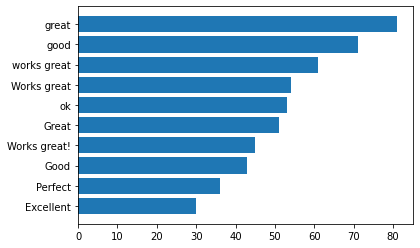

In [202]:
import matplotlib.pyplot as plt

words = [w[0] for w in wf_most_common]
freqs = [w[1] for w in wf_most_common]
freqs, words = zip(*sorted(zip(freqs, words)))

plt.barh(words, freqs)
plt.show()

# 1.1.1 Nube de Palabras

In [203]:
try:
    from wordcloud import WordCloud
except:
    !pip install wordcloud
    from wordcloud import WordCloud

In [204]:
 def plot_word_cloud(text):
    wordcloud = WordCloud(max_font_size=50, max_words=300, background_color="white").generate(' '.join(text))
    plt.figure( figsize=(19,6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

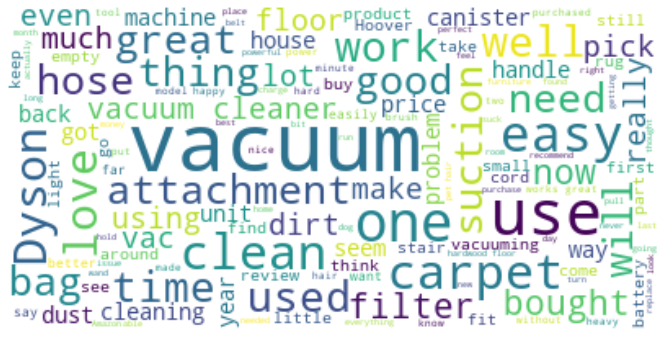

In [205]:
words_nltk= datatowork['reviewText'].apply(str)
plot_word_cloud(words_nltk)

In [212]:
#tokenizamos
datatokenizada = datatowork
datatokenizada['reviewText']= datatokenizada['reviewText'].apply(str).apply(word_tokenize)

In [213]:
datatokenizada.head()

,overall,reviewText
0,4,"[good, product, and, price]"
1,5,"[These, belts, are, $, 2+, retail, and, some, ..."
2,5,"[These, came, in, a, 2, pk, and, are, perfect,..."
3,5,"[So, my, super, fancy, vacuum, cleaner, ,, the..."
4,4,"[Right, one, for, my, eureka, .]"


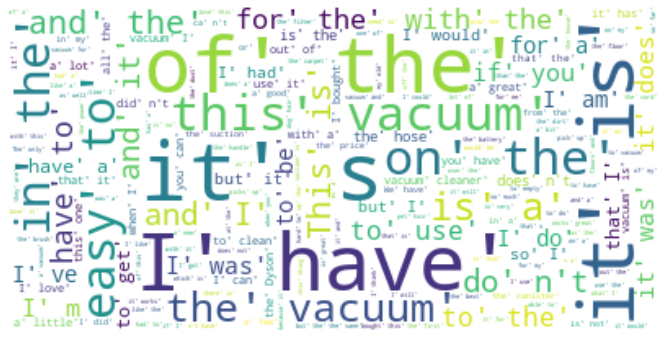

In [214]:
words_nltk= datatokenizada['reviewText'].apply(str)
plot_word_cloud(words_nltk)

# 2. Procesado de Texto / Normalización

A continuación aplicaremos algunas técnicas de normalización de texto sobre los reviews de amazon como son:
- Conversión a minúsculas
- Eliminación de comas,
- Elminación de stop words, etc. 


In [215]:
# Carga de librerías
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords

import os
import spacy

In [219]:
datatonormalize = datatowork
datatonormalize['reviewText'] = datatonormalize['reviewText'].apply(str)

In [220]:
#disminuimos a minúsculas y eliminamos signos de puntuación
datatonormalize['reviewText'] = datatonormalize['reviewText'].str.lower().str.replace('[^\w\s]','')

In [221]:
datatonormalize.head()

,overall,reviewText
0,4,good product and price
1,5,these belts are 2 retail and some retailersse...
2,5,these came in a 2 pk and are perfect fit for m...
3,5,so my super fancy vacuum cleaner the one with...
4,4,right one for my eureka


In [222]:
#tokenizamos
datatonormalize['reviewText'] = datatonormalize['reviewText'].apply(str).apply(word_tokenize)

In [223]:
datatonormalize.head(10)

,overall,reviewText
0,4,"[good, product, and, price]"
1,5,"[these, belts, are, 2, retail, and, some, reta..."
2,5,"[these, came, in, a, 2, pk, and, are, perfect,..."
3,5,"[so, my, super, fancy, vacuum, cleaner, the, o..."
4,4,"[right, one, for, my, eureka]"
5,5,"[great, item, just, as, described]"
6,5,"[oem, good, quality, belt]"
7,4,"[works, well, on, floor, not, that, good, in, ..."
8,4,"[this, vacuum, is, very, good, for, cleaning, ..."
9,5,"[a, powerful, little, vacuum, that, works, har..."


In [224]:
#Invocamos librearia NTLK para importar los stopwords en idioma inglés. 
try:
    from nltk.corpus import stopwords
    stop_words = set(stopwords.words('english'))
except:
    import nltk
    nltk.download('stopwords')
    from nltk.corpus import stopwords
    stop_words = set(stopwords.words('english'))

In [225]:
# Eliminamos stopwords.
datatonormalize['reviewText']=datatonormalize['reviewText'].apply(
                                lambda x: [item for item in x if item not in stop_words])


In [226]:
datatonormalize.head()

,overall,reviewText
0,4,"[good, product, price]"
1,5,"[belts, 2, retail, retailerssellers, use, gene..."
2,5,"[came, 2, pk, perfect, fit, good, old, vac, se..."
3,5,"[super, fancy, vacuum, cleaner, one, cold, fus..."
4,4,"[right, one, eureka]"


# 2.1 Visualización de los datos normalizados

Creamos un diccionario con el vocabulario (palabras/tokens presentes en el texto) y el número de veces que aparecen de la data normalizada

In [227]:
#destokenizar
datatonormalize['reviewText'] = [' '.join(x) for x in datatonormalize['reviewText']]
datatonormalize.head()

,overall,reviewText
0,4,good product price
1,5,belts 2 retail retailerssellers use genericnon...
2,5,came 2 pk perfect fit good old vac seem strong...
3,5,super fancy vacuum cleaner one cold fusion rea...
4,4,right one eureka


In [228]:
from collections import Counter
wf = Counter(datatonormalize['reviewText'])

In [229]:
wf_most_common = wf.most_common(10)
wf_most_common

[('works great', 215),
 ('great', 196),
 ('good', 167),
 ('love', 145),
 ('perfect', 99),
 ('ok', 98),
 ('great product', 84),
 ('works well', 68),
 ('good product', 68),
 ('expected', 68)]

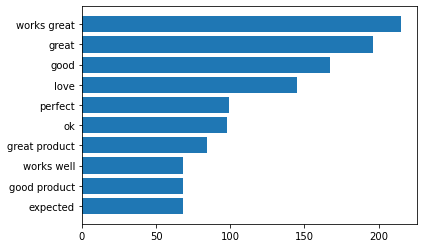

In [230]:
import matplotlib.pyplot as plt

words = [w[0] for w in wf_most_common]
freqs = [w[1] for w in wf_most_common]
freqs, words = zip(*sorted(zip(freqs, words)))

plt.barh(words, freqs)
plt.show()

# 2.1.1 Nube de Palabras

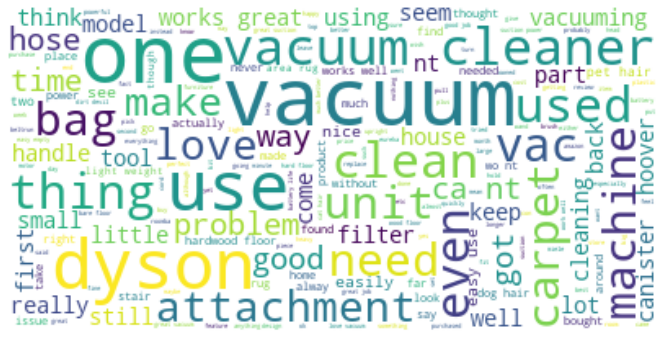

In [231]:
words_nltk= datatonormalize['reviewText'].apply(str)
plot_word_cloud(words_nltk)

In [232]:
#tokenizamos
datanormaltokenizada= datatonormalize
datanormaltokenizada['reviewText'] = datanormaltokenizada['reviewText'].apply(str).apply(word_tokenize)

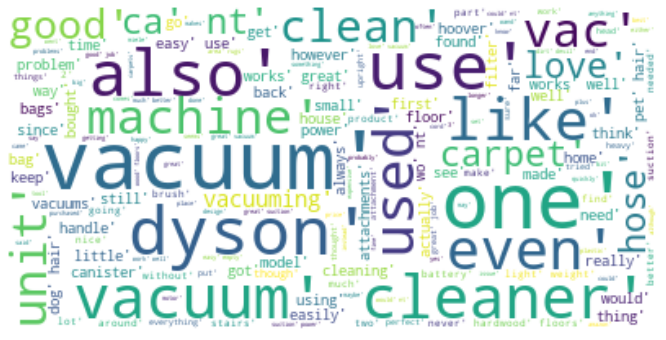

In [233]:
words_nltk= datanormaltokenizada['reviewText'].apply(str)
plot_word_cloud(words_nltk)

# 3. Entrenamiento de un modelo de análisis de sentimiento

# 3.1 Practicando con TexBlob

In [234]:
#Importación de Libtrerias
from textblob import TextBlob

Codificamos con un label el sentimiento:
- Si el valor es menor que 3 le asociamos la etiqueta 'neg' (negativo)
- En caso contrario, le asignamos 'pos' (positivo)
              
              


In [235]:
def label_sentiment(row):
    if int(row['overall']) < 3:
        return 'neg'
    else:
        if int(row['overall']) >3 :
            return 'pos'
        else : 
            return 'nulo'    

In [236]:
datatonormalize.head()

,overall,reviewText
0,4,"[good, product, price]"
1,5,"[belts, 2, retail, retailerssellers, use, gene..."
2,5,"[came, 2, pk, perfect, fit, good, old, vac, se..."
3,5,"[super, fancy, vacuum, cleaner, one, cold, fus..."
4,4,"[right, one, eureka]"


In [237]:
#Aplicamo
dataconsentimiento = datatonormalize
dataconsentimiento['reviewText'] = datatonormalize['reviewText'].apply(str)
dataconsentimiento['sentiment_label'] = dataconsentimiento.apply(lambda row: label_sentiment(row), axis=1)

In [238]:
dataconsentimiento.head(100)

,overall,reviewText,sentiment_label
0,4,"['good', 'product', 'price']",pos
1,5,"['belts', '2', 'retail', 'retailerssellers', '...",pos
2,5,"['came', '2', 'pk', 'perfect', 'fit', 'good', ...",pos
3,5,"['super', 'fancy', 'vacuum', 'cleaner', 'one',...",pos
4,4,"['right', 'one', 'eureka']",pos
...,...,...,...
95,3,"['annoying', 'everything', 'gets', 'stuck', 'e...",nulo
96,2,"['power', 'switch', 'stopped', 'working', '30t...",neg
97,5,['job'],pos
98,4,"['great', 'canister', 'vacuum', 'great', 'hard...",pos


In [239]:
#Eliminamos la calificación Neutra
dataconsentimiento = dataconsentimiento.loc[dataconsentimiento["sentiment_label"]!='nulo']


In [240]:
dataconsentimiento.sample(n=10, random_state=1)

,overall,reviewText,sentiment_label
64,1,"['defective', 'quality', 'control', 'obviously...",neg
11085,5,"['great', 'product', 'fast', 'delivery', 'perf...",pos
3,5,"['super', 'fancy', 'vacuum', 'cleaner', 'one',...",pos
33903,5,"['brush', 'fits', 'nicely', 'end', 'new', 'vac...",pos
40361,1,"['robot', 'great', 'part', 'gets', 'job', 'don...",neg
17397,5,"['amazed', 'convenience', 'vacuum', 'vacuum', ...",pos
27030,4,"['good', 'suction', 'size', 'attachments', 're...",pos
16445,5,"['saved', '180', 'new', 'vaccum', 'finding', '...",pos
7543,5,"['belt', 'replaced', '2', '3', 'bag', 'changes']",pos
22789,5,"['simply', 'love', 'looking', 'something', 'cl...",pos


Podemos ver como para una frase en la que se expresa un sentimiento positivo los valores de polaridad y subjetividad estimados se corresponden con lo esperado.

In [241]:
dataconsentimiento['prediction'] = dataconsentimiento['reviewText'].apply(lambda x: TextBlob(x).sentiment)

In [242]:
dataconsentimiento.sample(n=10, random_state=1)

,overall,reviewText,sentiment_label,prediction
64,1,"['defective', 'quality', 'control', 'obviously...",neg,"(0.08452380952380951, 0.4714285714285714)"
11085,5,"['great', 'product', 'fast', 'delivery', 'perf...",pos,"(0.6, 0.6875)"
3,5,"['super', 'fancy', 'vacuum', 'cleaner', 'one',...",pos,"(0.05221354166666667, 0.43385416666666665)"
33903,5,"['brush', 'fits', 'nicely', 'end', 'new', 'vac...",pos,"(0.36818181818181817, 0.7272727272727273)"
40361,1,"['robot', 'great', 'part', 'gets', 'job', 'don...",neg,"(0.21666666666666667, 0.5277777777777778)"
17397,5,"['amazed', 'convenience', 'vacuum', 'vacuum', ...",pos,"(0.061111111111111116, 0.06666666666666667)"
27030,4,"['good', 'suction', 'size', 'attachments', 're...",pos,"(0.12956349206349205, 0.4323412698412698)"
16445,5,"['saved', '180', 'new', 'vaccum', 'finding', '...",pos,"(0.44242424242424244, 0.5511363636363636)"
7543,5,"['belt', 'replaced', '2', '3', 'bag', 'changes']",pos,"(0.0, 0.0)"
22789,5,"['simply', 'love', 'looking', 'something', 'cl...",pos,"(0.5666666666666667, 0.675)"


In [243]:
print(datatowork.value_counts(dataconsentimiento['sentiment_label'], sort = False))

sentiment_label
neg     5473
pos    32421
dtype: int64


# 3.2 Preparación de los conjuntos de train y test para MLFLOW

In [244]:
from sklearn.model_selection import train_test_split

In [245]:
X_train, X_test, y_train, y_test = train_test_split(
    dataconsentimiento['reviewText'],
    dataconsentimiento['sentiment_label'],
    train_size=0.75,
    test_size=0.25,
    random_state=42,
    shuffle=True
)

In [246]:
X_train.iloc[:10]

1255     ['strong', 'suction', 'used', 'hardwood', 'flo...
16938    ['design', 'dust', 'buster', 'many', 'many', '...
30206    ['save', 'money', 'comes', 'two', 'fat', 'stif...
27759    ['edit', '2', 'never', 'ever', 'buying', 'dyso...
40588    ['perfect', 'replacement', 'filters', 'shark',...
40980             ['fir', 'price', 'excellent', 'quality']
13792    ['light', 'weight', 'easy', 'use', 'good', 'pi...
19944    ['new', 'apartment', 'space', 'constraints', '...
40666    ['love', 'love', 'love', 'even', 'go', 'detail...
5182     ['dirt', 'devil', 'cone', 'looks', 'nice', 'qu...
Name: reviewText, dtype: object

In [247]:
y_train.iloc[:10]

1255     pos
16938    neg
30206    neg
27759    neg
40588    pos
40980    pos
13792    pos
19944    pos
40666    pos
5182     pos
Name: sentiment_label, dtype: object

# 3.3 Extracción de características

Extraemos las características.

Para ello, calcularemos la matriz documento-término con los valores del TF-IDF como pesos, con el módulo de extracción de características de textos de scikit-learn [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html).

Lo que este modelo nos va a ayudar es a:
- Entrenar un modelo de bolsa de palabras (cada documento / review está compuesto por un conjunto de palabras)
- Cada palabra en cada review tendrá asociado un peso (TF-IDF)
- Palabras muy comunes en todos los documentos tendrán un score (TF-IDF) bajo
- Palabras muy frecuentes en solo ciertos documentos tendrán un score (TF_IDF) alto 

In [248]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [249]:
cv = TfidfVectorizer(
    max_df=0.95,  # Elimina el 5% de los tokens más comunes
    min_df=5,  # No tiene en cuenta aquellos tokens que aparezcan menos de 5 veces
    max_features=2500,  # Máximo de 2500 tokens en el vocabulario
    strip_accents='ascii',  # Elimina acentos durante la normalización
    ngram_range=(2, 3)  # Identificará y utilizará como features bigramas y trigramas
)
cv.fit(X_train)

TfidfVectorizer(max_df=0.95, max_features=2500, min_df=5, ngram_range=(2, 3),
                strip_accents='ascii')

Podemos ver algunas de las características (bigramas y trigramas en este caso) que hemos extraído.

In [250]:
print(list(cv.vocabulary_.items())[:40])

[('strong suction', 1907), ('hardwood floors', 970), ('floors area', 727), ('area rugs', 71), ('rugs nt', 1785), ('nt issue', 1403), ('mighty mite', 1261), ('15 years', 5), ('hardwood floors area', 971), ('floors area rugs', 728), ('dust buster', 490), ('many years', 1256), ('years ago', 2488), ('little longer', 1151), ('30 years', 13), ('battery life', 135), ('especially price', 594), ('black decker', 182), ('much better', 1278), ('dirt devil', 457), ('save money', 1792), ('comes two', 368), ('canister vacuum', 246), ('half price', 934), ('way better', 2332), ('better job', 164), ('dog cat', 473), ('bedroom apartment', 146), ('would buy', 2438), ('clean vacuum', 337), ('vacuum every', 2180), ('every time', 616), ('want use', 2322), ('time use', 1997), ('filter every', 668), ('every use', 620), ('buying new', 224), ('new vacuum', 1349), ('nice vacuum', 1361), ('every time use', 617)]


Confirmamos que el tamaño del vocabulario tiene un tamaño de 2500 tokens.

In [254]:
print(len(cv.vocabulary_))

2500


Transformamos nuestros datos.

In [255]:
X_train_ = cv.transform(X_train)
X_test_ = cv.transform(X_test)

# 3.4 Entrenamiento

Al estar en un problema de clasificación binaria, entrenamos una Regresión Logística y analizamos los resultados.

In [256]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [321]:
c_params = [0.01, 0.05, 0.25, 0.5, 1, 10, 100, 1000, 10000]

train_acc = list()
test_acc = list()

for c in c_params:
    lr = LogisticRegression(C=c, solver='lbfgs', max_iter=2000)
    lr.fit(X_train_, y_train)
    
    train_predict = lr.predict(X_train_)
    test_predict = lr.predict(X_test_)
    
    print ("Accuracy for C={}: {}".format(c, accuracy_score(y_test, test_predict)))
    
    train_acc.append(accuracy_score(y_train, train_predict))
    test_acc.append(accuracy_score(y_test, test_predict))

Accuracy for C=0.01: 0.8567658855815917
Accuracy for C=0.05: 0.8581380620645979
Accuracy for C=0.25: 0.8829427907958624
Accuracy for C=0.5: 0.8942368587713743
Accuracy for C=1: 0.9016255013721765
Accuracy for C=10: 0.9061642389698121
Accuracy for C=100: 0.8989867004433185
Accuracy for C=1000: 0.8941313067342199
Accuracy for C=10000: 0.8929702343255225


# 3.5 Generación de Métricas (Probando el modelo)

In [322]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

In [323]:
print('Confussion matrix:\n{}'.format(confusion_matrix(y_test, test_predict)))
print('\nClassification report:\n{}'.format(classification_report(y_test, test_predict)))
print('Accuracy score:{}'.format(accuracy_score(y_test, test_predict)))

Confussion matrix:
[[ 743  614]
 [ 400 7717]]

Classification report:
              precision    recall  f1-score   support

         neg       0.65      0.55      0.59      1357
         pos       0.93      0.95      0.94      8117

    accuracy                           0.89      9474
   macro avg       0.79      0.75      0.77      9474
weighted avg       0.89      0.89      0.89      9474

Accuracy score:0.8929702343255225


In [324]:
classification_report(y_test, test_predict)

print("precision neg:",precision_score(y_test, test_predict, labels=['neg'], average=None))
print("precision pos:",precision_score(y_test, test_predict, labels=['pos'], average=None)) 
print("f1 neg:",f1_score(y_test, test_predict, labels=['neg'], average=None))
print("f1 pos:",f1_score(y_test, test_predict, labels=['pos'], average=None))  
print("recall neg:",recall_score(y_test, test_predict, labels=['neg'], average=None))
print("recall pos:",recall_score(y_test, test_predict, labels=['pos'], average=None))

precision neg: [0.65004374]
precision pos: [0.92629936]
f1 neg: [0.5944]
f1 pos: [0.93835117]
recall neg: [0.54753132]
recall pos: [0.95072071]


In [260]:
import numpy as np
from matplotlib import pyplot as plt

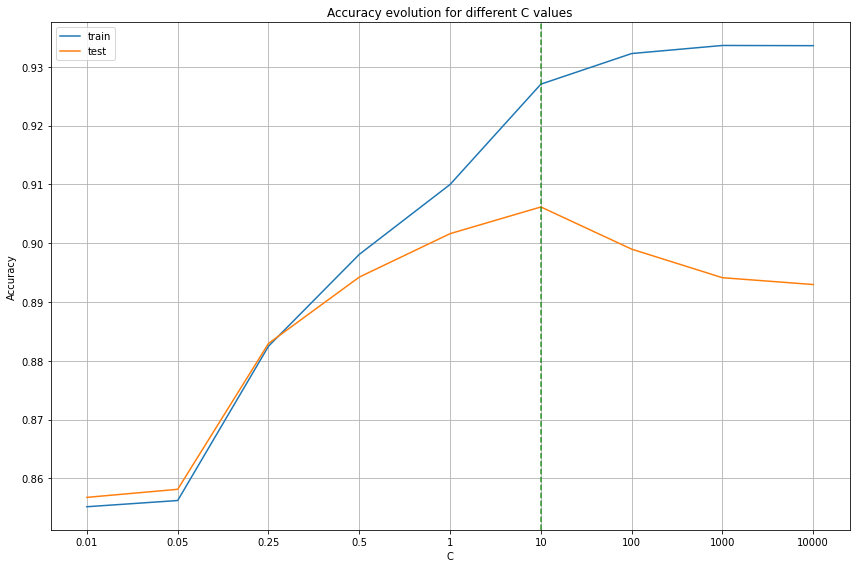

In [261]:
plt.figure(figsize=(12, 8))
plt.plot(train_acc, label='train')
plt.plot(test_acc, label='test')
plt.axvline(np.argmax(test_acc), c='g', ls='--', alpha=0.8)
plt.title('Accuracy evolution for different C values')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.xticks(list(range(len(c_params))), c_params)
plt.tight_layout()
plt.show()

# 4.Registro de métricas en distintos experimentos con MLflow

In [262]:
import logging

logging.basicConfig(level=logging.WARN)
logger = logging.getLogger(__name__)

In [263]:
import numpy as np
import mlflow
import mlflow.sklearn
from urllib.parse import urlparse
from sklearn.linear_model import ElasticNet

np.random.seed(0)
mlflow.set_tracking_uri("file:////Users/danielames/mlruns")

In [317]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

In [333]:
c_params = [0.01, 0.05, 0.25, 0.5, 1, 10, 100, 1000, 10000]

train_acc = list()
test_acc = list()

    # Entrenamiento del modelo
for c in c_params:
     
    #Inicio del programa de registro
    with mlflow.start_run():
        lr = LogisticRegression(C=c, solver='lbfgs', max_iter=500)
        lr.fit(X_train_, y_train)

        train_predict = lr.predict(X_train_)
        test_predict = lr.predict(X_test_)

        print('Confussion matrix:\n{}'.format(confusion_matrix(y_test, test_predict)))
        print('\nClassification report:\n{}'.format(classification_report(y_test, test_predict)))
  
        
        print("precision neg:",precision_score(y_test, test_predict, labels=['neg'], average=None))
        print("precision pos:",precision_score(y_test, test_predict, labels=['pos'], average=None)) 
        print("f1 neg:",f1_score(y_test, test_predict, labels=['neg'], average=None))
        print("f1 pos:",f1_score(y_test, test_predict, labels=['pos'], average=None))  
        print("recall neg:",recall_score(y_test, test_predict, labels=['neg'], average=None))
        print("recall pos:",recall_score(y_test, test_predict, labels=['pos'], average=None))

        print ("Accuracy for C={}: {}".format(c, accuracy_score(y_test, test_predict)))
        
        train_acc.append(accuracy_score(y_train, train_predict))
        test_acc.append(accuracy_score(y_test, test_predict))


        # Registro de métricas en MLflow Tracking
        mlflow.log_param("c",c)
        
        mlflow.log_metric("Precision_Neg", float(precision_score(y_test, test_predict, labels=['neg'], average=None)))
        mlflow.log_metric("Precision Pos", float(precision_score(y_test, test_predict, labels=['pos'], average=None)))
        mlflow.log_metric("F1 neg",float(f1_score(y_test, test_predict, labels=['neg'], average=None)))
        mlflow.log_metric("F1 pos",float(f1_score(y_test, test_predict, labels=['pos'], average=None)) )      
        mlflow.log_metric("Recall neg",float(recall_score(y_test, test_predict, labels=['neg'], average=None)))
        mlflow.log_metric("Recall pos",float(recall_score(y_test, test_predict, labels=['pos'], average=None)) )       
        mlflow.log_metric("Accuracy", accuracy_score(y_test, test_predict))

        tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

        # Registro del modelo
        if tracking_url_type_store != "file":
                mlflow.sklearn.log_model(lr, "model", registered_model_name="AnálisisPrimerEscenario")
        else:
                mlflow.sklearn.log_model(lr, "model")


Confussion matrix:
[[   0 1357]
 [   0 8117]]

Classification report:
              precision    recall  f1-score   support

         neg       0.00      0.00      0.00      1357
         pos       0.86      1.00      0.92      8117

    accuracy                           0.86      9474
   macro avg       0.43      0.50      0.46      9474
weighted avg       0.73      0.86      0.79      9474

precision neg: [0.]
precision pos: [0.85676589]
f1 neg: [0.]
f1 pos: [0.92285828]
recall neg: [0.]
recall pos: [1.]
Accuracy for C=0.01: 0.8567658855815917
Confussion matrix:
[[  13 1344]
 [   0 8117]]

Classification report:
              precision    recall  f1-score   support

         neg       1.00      0.01      0.02      1357
         pos       0.86      1.00      0.92      8117

    accuracy                           0.86      9474
   macro avg       0.93      0.50      0.47      9474
weighted avg       0.88      0.86      0.79      9474

precision neg: [1.]
precision pos: [0.85794313]
f1